## import libraries and add simulation backends

In [1]:
from qiskit import IBMQ, ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, BasicAer, execute, transpile, assemble
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import quantum_info
from qiskit.aqua.utils.subsystem import *
from qiskit.providers.aer import AerSimulator

import os, time
import numpy as np
import math, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import chirp, find_peaks, peak_widths

simulator = AerSimulator()
backend = simulator
pi = np.pi
cos = np.cos
sin = np.sin

# 1. Testing nonlocal conditions

## 1.1. Quantum circuit using post-selection
- To test the $1^{st}$ nonlocal condition, we do not apply the `qc.ry(-theta,q)` gates.
- To test the $2^{nd}$ nonlocal conditions, we apply the `qc.ry(-theta,q[k])` gates on $k^{th}$ qubit.
- To test the $3^{rd}$ nonlocal conditions, we apply the `qc.ry(-theta,q)` on all gates.

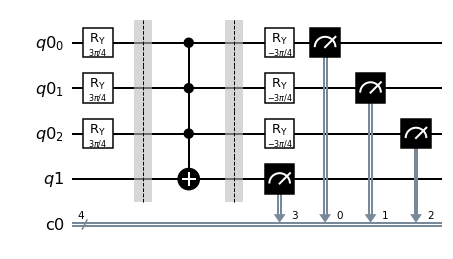

In [2]:
Asqr = 1/2
A = np.sqrt(Asqr)
theta = np.arcsin(A)*2
n=3

q = QuantumRegister(n)
anc = QuantumRegister(1)
c = ClassicalRegister(n+1)
qc = QuantumCircuit(q,anc, c)

theta = 3*pi/4
qc.ry(theta,q)
qc.barrier()
qc.mct(q[0:n],anc[0],mode='noancilla') 
qc.barrier()
qc.ry(-theta,q)
qc.measure(q[0:n], c[0:n])
qc.measure(anc,c[n:n+1])
qc.draw(output = 'mpl',style='bw')

### Measurement
- The $1^{st}$ nonlocal condition will show that there is no $|111...\rangle$ state when measuring all qubits in the $|u\rangle,|v\rangle$ basis.
- The $2^{nd}$ nonlocal conditions will show that if the $k^{th}$ qubit is measured at `1` in the $|c\rangle,|d\rangle$ basis, then all others qubits in $|u\rangle,|v\rangle$ basis will also `1`. 
- The $3^{rd}$ nonlocal conditions will show a non-zero probability of measuring 2 `1` or more in $|c\rangle,|d\rangle$ basis, which should constitute a paradox for local-hidden-variable (LHV) theory.

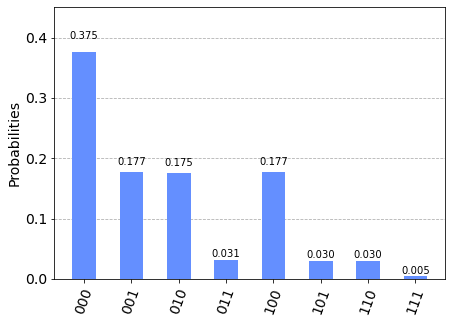

In [3]:
shots = 100000
job = execute(qc, backend=simulator, shots=shots)
counts = job.result().get_counts(qc)
explode = 0
for k, v in list(counts.items()):
    i=0
    for p in range(1):
        if (k[i] == '1'):
            explode = explode + v
            del counts[k]
            break
        i+=1

for k,v in list(counts.items()):
    counts[k[1:]]=counts.pop(k)
plot_histogram(counts)

## 1.2. Experiment on IBM Nairobi
For A = 0.9. First, theoretical predictions using Qiskit simulator:

[0.0146385  0.06240623 0.06240623 0.26604761 0.06240623 0.26604761
 0.26604761 0.        ]


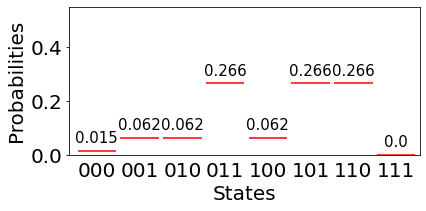

[7.70447265e-02 3.28453834e-01 1.92592994e-34 0.00000000e+00
 3.28453834e-01 5.05490451e-02 0.00000000e+00 2.15498560e-01]


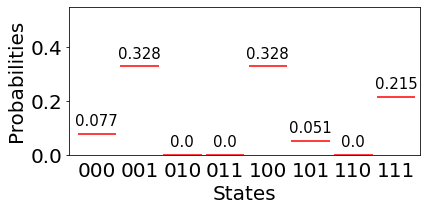

[0.468559   0.14138861 0.14138861 0.03316523 0.14138861 0.03316523
 0.03316523 0.0077795 ]


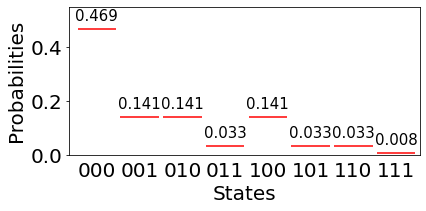

In [4]:
from sklearn.preprocessing import normalize

#theory
shots = 20000
repeat = 100
n = 3
qcshots = shots*repeat
shots = qcshots

nairobi = 'ibm_nairobi'
backend = nairobi
theores = {}
u_diag = np.ones(2**n,dtype='int8')
u_diag[-1] = 0

#vector after rotation
A_exp = 0.9
theta = np.arcsin(A_exp)*2
rot = np.array([cos(theta/2),sin(theta/2)])
rotation = rot
for i in range(n-1):
    rotation = np.kron(rotation,rot)

for case in range(3):
    #second rotation, no need when calculate entropy
    I = np.identity(2)
    if case == 0:
        v = u_diag*rotation
        v = normalize(v.reshape(-1, 1),axis=0).T[0]

    elif case == 1:
        rotm = np.matrix([[cos(-theta/2),-sin(-theta/2)],[sin(-theta/2),cos(-theta/2)]])
        rotationm = np.kron(np.kron(I,rotm),I)
        v = u_diag*rotation
        v = normalize(v.reshape(-1, 1),axis=0).T[0]
        v = np.array(rotationm@v)[0]

    else:
        rotm = np.matrix([[cos(-theta/2),-sin(-theta/2)],[sin(-theta/2),cos(-theta/2)]])
        rotationm = rotm
        for i in range(n-1):
            rotationm = np.kron(rotationm,rotm)
        v = u_diag*rotation
        v = normalize(v.reshape(-1, 1),axis=0).T[0]
        v = np.array(rotationm@v)[0]

    #vector after both rotation and non-unitary evolution
    #measurement
    meas = v*v #if complex, v*v.conj()
    theores[case] = meas
cm = 1/2.54  
for j in range(3):
    
    names = ['000','001','010','011','100','101','110','111']

    fig = plt.figure(figsize=(15.96*cm , 6.913*cm))
    #fig = plt.figure(figsize=(6.5,3))
    ax = fig.add_subplot(111)
    n_groups = 8
    index = np.arange(n_groups)
    bar_width = 0.9
    opacity = 1


    plt.xlim(-0.2,8)
    plt.ylim(bottom=0, top = 0.55)
    plt.xlabel('States',size=20)
    plt.ylabel('Probabilities',size=20)
    #plt.title('Distirbution')
    plt.xticks(index + bar_width/2, names)
    plt.tick_params(axis="x", labelsize=20,bottom=False)
    plt.tick_params(axis="y", labelsize=20)
    
    for i in range(8):
        plt.hlines(theores[j%3][i], i, i+bar_width, color='red', linestyle='solid', label = 'Theory')

    #show probabilies on top
    for i, v in enumerate(theores[j%3]):
        plt.text(index[i]+bar_width/2, v + 0.03, str(np.round(v,3)),size=15, ha='center')

    #plt.savefig('case%s_theory.svg'%j, transparent = True, dpi=240)
    print(theores[j%3])
    plt.show()
shots = qcshots/repeat

### data and figures
Nairobi device:

In [5]:
#std of results
n=3
state_probforvar = []
j=0
for j in range(3): #case
    state_probforvar.append([])
    j+=1

countlist = {}
j=0

for j in range(3): #case
    countlist[j%3] = np.load(os.path.join('data','uToff_raw_%s_%s_%s'%(n,backend,j)),allow_pickle='True')
    for l in range(100):
        d=countlist[j%3][l]
        d1 = { k: d[k]/sum(d[k] for k in d) for k in d }
        state_probforvar[j%3].append(list(d1.values()))

std2 = np.std(state_probforvar,1)
print(std2)

[[0.00821162 0.01320952 0.00209728 0.01307808 0.00757877 0.00493391
  0.0122622  0.00094202]
 [0.00532202 0.00804756 0.00380674 0.00186719 0.01783244 0.00970979
  0.00222627 0.01197541]
 [0.0254344  0.01371971 0.03179434 0.00367264 0.00279768 0.00591554
  0.01132688 0.00338214]]


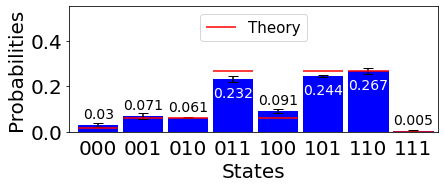

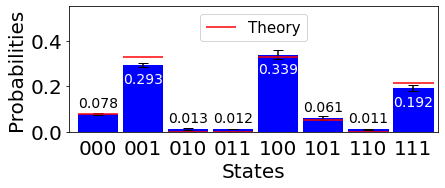

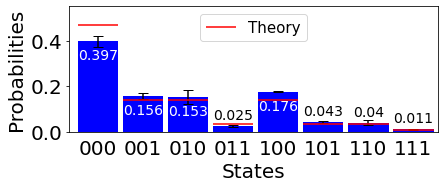

In [6]:
shots = 20000
repeat = 100
n = 3
qcshots = shots*repeat
shots = qcshots

cm = 1/2.54
colorlist = [['k','k','k','w','k','w','w','k'],['k','w','k','k','w','k','k','w'],
            ['w','w','w','k','w','k','k','k']]
labellist = ['Theory','','','','','','','']
for j in range(3):
    counts_draft = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0} 
    counts = np.load(os.path.join('data','uToff_count_%s_%s_%s_m'%(n,backend,j)),allow_pickle='True')
    counts = {**counts_draft,**counts}
    counts = dict(sorted(counts.items()))
    list1 = list(counts.values())
    a = [x/(shots) for x in list1] #probability of states
    names = list(counts.keys())

    fig = plt.figure(figsize=(15.96*cm , 6.913*cm))
    #fig = plt.figure(figsize=(6.5,3))
    ax = fig.add_subplot(111)
    n_groups = 8
    index = np.arange(n_groups)
    bar_width = 0.9
    opacity = 1

    rects1 = plt.bar(index+bar_width/2, a, bar_width, alpha=opacity, color='b')
    plt.errorbar(index+bar_width/2,a,yerr=std2[j%3],ls='none',color='k', capsize=5)

    plt.xlim(-0.2,8)
    plt.ylim(bottom=0, top = 0.55)
    plt.xlabel('States',size=20)
    plt.ylabel('Probabilities',size=20)
    #plt.title('Distirbution')
    plt.xticks(index + bar_width/2, names)
    plt.tick_params(axis="x", labelsize=20,bottom=False)
    plt.tick_params(axis="y", labelsize=20)
    
    for i in range(8):
        plt.hlines(theores[j%3][i], i, i+bar_width, color='red', linestyle='solid', label = labellist[i])
    plt.legend(loc='upper center',fontsize=15)
    plt.tight_layout()

    #show probabilies on top
    for i, v in enumerate(a):
        if colorlist[j%3][i] == 'w':
            a = -0.08
        else:
            a = 0.03
        plt.text(index[i]+bar_width/2, v + a, str(np.round(v,3)),size=14, ha='center', 
                 color = colorlist[j%3][i])


    #plt.savefig('case%s_nairobi_m.svg'%(j%3), transparent = True, dpi=240)
    plt.show()
shots = qcshots/repeat

Quantum circuits for $n$ = 3 and their results executed at $A$ = 0.9, corresponding to a rotation of $\theta = 0.713\pi$. Numbers on the histogram and the bars are theoretical probability obtained from a quantum simulator, and red dots are experimental result from IBM's Nairobi.

**(top)** The first set of nonlocal condition. A quantum state $|\Psi_3\rangle$ is prepared without $|u_1u_2u_3rangle$, as evident from the probability of $|111rangle$.

**(middle)** The second set of nonlocal conditions. Rotating the second qubit back to $\{|c_2\rangle,|d_2\rangle\}$ while leaving other qubits in $\{|u\rangle,|v\rangle\}$ such that the second conditions are established. Evidently, $D_2 = 1 \Rightarrow U_1U_3=1$.

**(bottom)** The last nonlocal conditions is realized by applying $R_Y(\theta)$ on all qubits. States $|011\rangle, |101\rangle, |110\rangle, |111\rangle$ yield nonzero probabilities, thus establishes a Hardy-type paradox.

# 2. Nonlocal probability

## 2.1. Theory

Plotting $	P_\text{nonlocal}=A^{2n}-n\frac{A^{4n-2}(1-A^{2})}{1-A^{2n}}. $

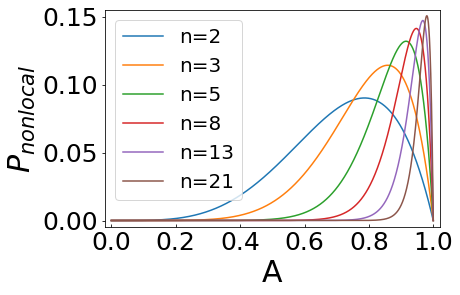

In [7]:
np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
x=np.linspace(0,1,10**6+1)

for n in [2,3,5,8,13,21]:    
    y0 = (x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
    plt.plot(x,y0,label='n=%s'%n)

plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=25) 
plt.tick_params(axis="y", labelsize=25)

plt.xlabel('A',size=30)
plt.ylabel('$P_{nonlocal}$',size=30)
plt.legend(loc = 'upper left',fontsize=20)
plt.yticks([0,0.05,0.1,0.15])
plt.xticks([0,0.2,0.4,0.6,0.8,1])
plt.xlim(-0.02, 1.02)
plt.ylim(bottom=-0.005, top = 0.155)
plt.show()

Calculate optimal $A$ and $P_{nonlocal}$ for large $n$.

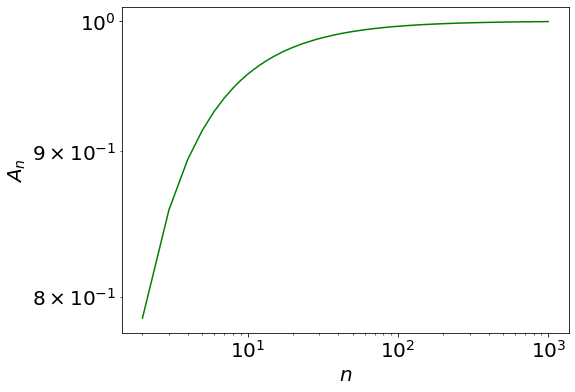

In [8]:
#log-log scale
np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning
plist = []
nlist = []
Alist = []
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

for n in range(2,1000):
    nlist.append(n)
    x=np.linspace(0,1,10**4+1)
    y=(x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
    maxy0 = max(y) #find maximal nonlocal probability for each n
    A0=x[np.nanargmax(y)]
    plist.append(maxy0)
    Alist.append(A0)

plt.plot(nlist, Alist, color = 'green',label=r'$A_n$')
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

#plt.legend(fontsize='15',loc='upper right')#, bbox_to_anchor=(1,0.575))
plt.xlabel(r'$n$',fontsize='20')
plt.ylabel(r'$A_n$',fontsize='20')
plt.show()

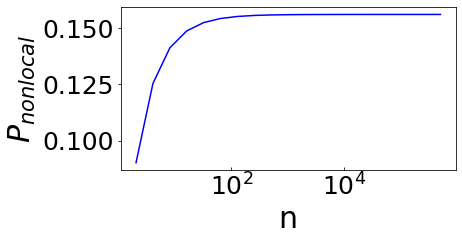

In [9]:
#lin-log scale
np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning
plist = []
nlist = []
Alist = []
fig = plt.figure(figsize=(6,3))
ax = plt.subplot(111)

for i in range(1,20):
    n = 2**i
    nlist.append(n)
    x=np.linspace(0,1,2**(i+4)+1)
    y=(x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
    maxy0 = max(y) #find maximal nonlocal probability for each n
    A0=x[np.nanargmax(y)]
    plist.append(maxy0)
    Alist.append(A0)
plt.plot(nlist, plist, color = 'blue')
plt.xscale('log')
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=25) 
plt.tick_params(axis="y", labelsize=25)

plt.xlabel('n',size=30)
plt.ylabel('$P_{nonlocal}$',size=30)
plt.show()

Calculate FWHM and Integral of $P_{nonlocal}$ curve to $A$ for each $n$

In [10]:
import time
np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning

nlist = []
fwhmlist = []
intlist = []
start = time.time()
for i in np.linspace(1,20,20):
    n = 2**i
    res = math.floor(2**(i+5))
    nlist.append(n)
    x=np.linspace(0,1,res,endpoint=False)
    y=(x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
    peaks, _ = find_peaks(y)
    results_half = peak_widths(y, peaks, rel_height=0.5)
    fwhmlist.append(results_half[0][0]/res)
    integr = np.trapz(y=y, x=x)
    intlist.append(integr)

end = time.time()
print(end-start) #time to calculate

25.045498371124268


[2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0, 8192.0, 16384.0, 32768.0, 65536.0, 131072.0, 262144.0, 524288.0, 1048576.0] [0.36829067699923046, 0.20175681467933837, 0.10537030694409677, 0.053823625065649194, 0.02719313696819914, 0.013666581791163201, 0.0068509199466800785, 0.00342992129644637, 0.0017160758020519085, 0.0008583166675020237, 0.0004292280226309009, 0.00021463143319355726, 0.00010732007202363114, 5.3661124863157994e-05, 2.6830834643720713e-05, 1.3415485374923541e-05, 6.7077597006859335e-06, 3.3538841036628853e-06, 1.6769431151475445e-06, 8.384718233056532e-07]


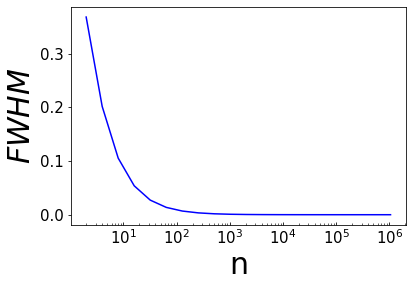

[2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0, 8192.0, 16384.0, 32768.0, 65536.0, 131072.0, 262144.0, 524288.0, 1048576.0] [0.03732713717865098, 0.030231912045126413, 0.01843626921586107, 0.010114905117651018, 0.005290986634245436, 0.002705114430204784, 0.0013676218117033181, 0.0006875972667608313, 0.00034474776890467817, 0.0001726114876806801, 8.636518464017329e-05, 4.319745752379299e-05, 2.1602445688582747e-05, 1.0802152154201096e-05, 5.40130841435889e-06, 2.700712292716715e-06, 1.3503706678955152e-06, 6.751889643511523e-07, 3.375953897788129e-07, 1.6879792179051423e-07]


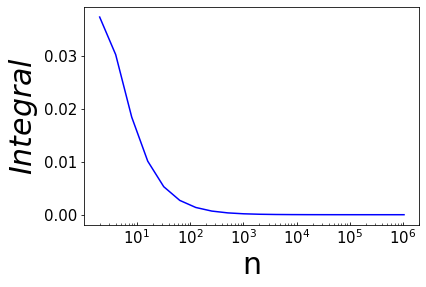

In [11]:
#lin-log scale
plt.plot(nlist, fwhmlist, color = 'blue')
print(nlist,fwhmlist)
plt.xscale('log')
#plt.yscale('log')
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=15) 
plt.tick_params(axis="y", labelsize=15)

plt.xlabel('n',size=30)
plt.ylabel('$FWHM$',size=30)
plt.show()

plt.plot(nlist, intlist, color = 'blue')
print(nlist,intlist)
plt.xscale('log')
#plt.yscale('log')
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=15) 
plt.tick_params(axis="y", labelsize=15)

plt.xlabel('n',size=30)
plt.ylabel('$Integral$',size=30)
plt.show()

[-0.99359381 -0.08367677] 
 [0.30103    0.60205999 0.90308999 1.20411998 1.50514998 1.80617997
 2.10720997 2.40823997 2.70926996 3.01029996 3.31132995 3.61235995
 3.91338994 4.21441994 4.51544993 4.81647993 5.11750993 5.41853992
 5.71956992 6.02059991] [-0.43380927 -0.69517179 -0.97728175 -1.26902706 -1.56554069 -1.8643401
 -2.16425111 -2.46471585 -2.76546353 -3.06635245 -3.36731193 -3.66830667
 -3.96931904 -4.27034023 -4.57136582 -4.87239361 -5.1734225  -5.47445195
 -5.77548167 -6.07651153]


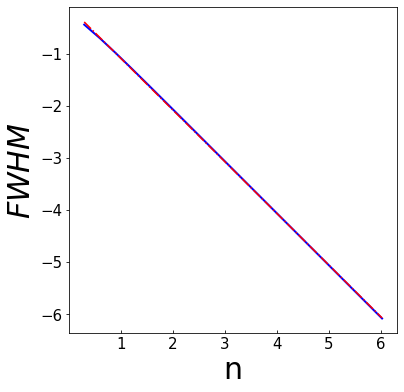

[-0.970088   -0.88142395] 
 [0.30103    0.60205999 0.90308999 1.20411998 1.50514998 1.80617997
 2.10720997 2.40823997 2.70926996 3.01029996 3.31132995 3.61235995
 3.91338994 4.21441994 4.51544993 4.81647993 5.11750993 5.41853992
 5.71956992 6.02059991] [-1.42797532 -1.51953438 -1.73432696 -1.99503819 -2.27646334 -2.56781436
 -2.86403398 -3.16266586 -3.46249854 -3.7629303  -4.06366129 -4.36454181
 -4.66549708 -4.96648971 -5.26750102 -5.56852168 -5.869547   -6.17057466
 -6.47160349 -6.7726329 ]


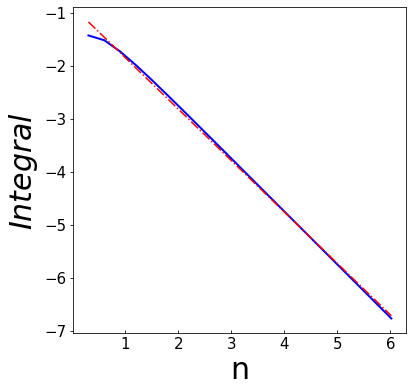

In [12]:
#log-log scale, finding slope and intercept
nlistlog,fwhmlistlog,intlistlog = np.log10(nlist), np.log10(fwhmlist), np.log10(intlist)

plt.figure(figsize=(6,6))
plt.plot(nlistlog, fwhmlistlog, color = 'blue',lw=2)
coeff = np.polyfit(nlistlog,fwhmlistlog, deg = 1)
print(coeff,'\n',nlistlog,fwhmlistlog)
y_prediction = np.polyval(coeff, nlistlog)
plt.plot(nlistlog, y_prediction, color = 'red',ls='-.')
#plt.xscale('log')
#plt.yscale('log')
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=15) 
plt.tick_params(axis="y", labelsize=15)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('n',size=30)
plt.ylabel('$FWHM$',size=30)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(nlistlog, intlistlog, color = 'blue',lw=2)
coeff = np.polyfit(nlistlog,intlistlog, deg = 1)
print(coeff,'\n',nlistlog,intlistlog)
y_prediction = np.polyval(coeff, nlistlog)
plt.plot(nlistlog, y_prediction, color = 'red',ls='-.')
#plt.xscale('log')
#plt.yscale('log')
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in", labelsize=15) 
plt.tick_params(axis="y", labelsize=15)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('n',size=30)
plt.ylabel('$Integral$',size=30)
plt.show()

## 2.2. Post-selection simulation
Comparision with theoretical formula above shows similar results.

In [13]:
#Results without simulation (to save time)
nondict = {2: [0, 0.012033484124291834, 0.05649553032405997, 0.08634461825497936, 0.08787820210183529, 0.07443688547066582, 0.05597152419265996, 0.04056944334423484, 0.026848328697937105, 0.018722424211057485, 0], 3: [0, 0.001881565566748989, 0.029423541953768947, 0.0796962874341752, 0.11056291202835439, 0.1118816611254389, 0.0932740114686518, 0.07203150274039291, 0.05174386030441685, 0.03543869176396395, 0], 4: [0, 0.00022705562862901417, 0.011762393571107267, 0.05536615078598153, 0.10426330341094822, 0.12449756340483051, 0.11687965688629555, 0.09477866236626908, 0.07205707920099944, 0.05047797791039941, 0], 5: [0, 3.3000957027753814e-05, 0.004246438033943383, 0.034139414442634596, 0.0870224612597684, 0.1255736087225602, 0.13071162308989415, 0.11375887039692192, 0.08819615336004821, 0.0649558285087552, 0], 6: [0, 7.000028000112001e-06, 0.0014941321265445784, 0.019723631840541562, 0.06790039219602034, 0.11680576006193163, 0.13625041804559315, 0.12617536833845194, 0.10228006366536055, 0.07653061224489803, 0], 7: [0, 1e-06, 0.0005062622438423102, 0.011145393038531248, 0.051177612447438084, 0.10528644837358908, 0.13529070572886145, 0.13420818082786468, 0.11449348368740833, 0.08876047855456988, 0], 8: [0, 0, 0.0001800289846665315, 0.006020592580069955, 0.03694371484338578, 0.09150842771532429, 0.13175677590888732, 0.13980477943617678, 0.12348310838279529, 0.0973901074022424, 0], 9: [0, 0, 4.600280617117648e-05, 0.0033624356436239714, 0.026554043175090723, 0.07778057512127991, 0.12603875708828424, 0.14278060770378925, 0.13151197240118517, 0.1063933225370945, 0], 10: [0, 0, 2.5000575013225316e-05, 0.0017891363560321124, 0.018885561831672684, 0.065048209707005, 0.11721143861432862, 0.14334520805898682, 0.13760866950724937, 0.11413663441632503, 0], 11: [0, 0, 7.000028000112001e-06, 0.0009208895793336477, 0.013114890499542906, 0.05454680395870829, 0.10870609570451512, 0.14158166169971248, 0.14159071746898547, 0.12156131855358149, 0], 12: [0, 0, 1.000001000001e-06, 0.0004922490780334794, 0.009159135048007172, 0.0445933713414523, 0.09948072691091671, 0.1391479371284954, 0.14595989646299193, 0.12819175703405392, 0], 13: [0, 0, 2.000002000002e-06, 0.0002970822917948267, 0.006411275953638012, 0.036623480029967945, 0.09063244474586085, 0.13513784224064024, 0.146275180812973, 0.13253407784529656, 0], 14: [0, 0, 0, 0.00013902071408639877, 0.004364671574787524, 0.02967544680957211, 0.08162742540041651, 0.12983664556341326, 0.14807006968264858, 0.13703481921950605, 0], 15: [0, 0, 0, 7.30059134789918e-05, 0.002910070690341786, 0.023944404426353105, 0.07302004432536352, 0.12373766278361294, 0.1483005584278527, 0.14095189379992304, 0], 16: [0, 0, 0, 4.000164006724277e-05, 0.002041172155886599, 0.01934121354109599, 0.06491736913128551, 0.11811066495972146, 0.14666563304877672, 0.1432386786812028, 0]}

D:\Temp\ipykernel_9948\2269725100.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


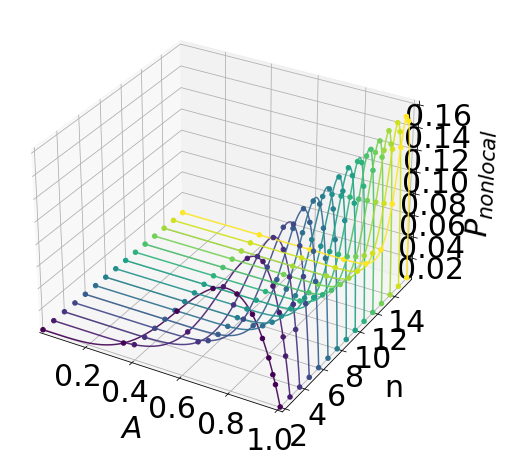

In [14]:
%matplotlib inline
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning

cmap = mpl.cm.get_cmap('viridis')
color_gradients = cmap(np.linspace(0,1,15)) 

for n in range(2,17):

    #-----------this run simulation result--------------------
    Asim= 1-np.flip(np.geomspace(10**-((1.7)), 1, num=10,endpoint=True))
    Asim =  np.append(Asim,np.float64(1))
    theta = np.arccos(Asim)*2
    y1 = nondict[n]
    
    #-----------this run theory-----------
    Afull = np.linspace(0,1,10**4)
    x=Afull
    y2 = (x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
    
    ax.plot(Afull, np.full((len(Afull),1), n), y2,color = color_gradients[n-2],linestyle='solid',alpha=0.9)
    ax.scatter(Asim, np.full((len(Asim),1), n), y1,color = color_gradients[n-2],marker='o', alpha=1)

ax.set_xlabel('$A$',fontsize = '30',labelpad=20)
ax.set_ylabel('n',fontsize = '30',labelpad=20)
ax.set_zlabel('$P_{nonlocal}$',fontsize = '30',labelpad=20)
#change fontsize
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(30)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(30)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(30)
ax.zaxis._axinfo['label']['space_factor']=0
ax.view_init(30, 300)
ax.set_xlim(xmin=0.02,xmax=1)
ax.set_ylim(2,(16-0.3))
ax.set_zlim(zmin = 0.003,zmax=0.16)

plt.show()

Nonlocal probability $P_\text{nonlocal}$ as a function of the transformation coefficient $A$ at different ensemble size $n$. Solid lines are analytical result, while dots are simulation result obtained from the QASM quantum simulator provided by IBM. 

## 2.3. Experiments on IBM Quito and IBM Nairobi
The IBM Quito circuits used post-selection and the 3-Toffoli gate, while the Nairobi circuits used unitary-prepared statevectors for qiskit state initialization.

## data and figures 

Quito device:

In [15]:
backend = 'ibmq_quito'
split = 8
A_exp = np.linspace(0.25,0.95,split)
tlist = np.arcsin(A_exp)*2
#calculate nonlocal probability from accumulated data
n=3
j=0
nonlist_m_quito = np.zeros(split)
for t in tlist:
    countssim3 = np.load(os.path.join('data','Toff_count_%s_%s_%s_m'%(n,backend,j)),allow_pickle='True')
    
    for k, v in list(countssim3.items()):
        i=0
        for p in range(1):
            if (k[i] == '1'):
                del countssim3[k]
                break
            i+=1

    for k,v in list(countssim3.items()):
        countssim3[k[1:]]=countssim3.pop(k)
    d = countssim3
    d1 = { k: d[k]/sum(d[k] for k in d) for k in d }
    nonloc = sum(v for k, v in d1.items() if (k.count('0') > 1) )
    nonlist_m_quito[j]+=nonloc
    j+=1
    
#calculate std for each 100 runs of 20000 shots of each theta from raw data
n=3
nonlist_mforvar = []
j=0
for t in tlist:
    nonlist_mforvar.append([])
    j+=1
    
countlist = {}
j=0
for t in tlist:
    countlist[j] = np.load(os.path.join('data','Toff_raw_%s_%s_%s'%(n,backend,j)),allow_pickle='True')
    for l in range(100):
        countssim3=countlist[j][l]
        for k, v in list(countssim3.items()):
            i=0
            for p in range(1):
                if (k[i] == '1'):
                    del countssim3[k]
                    break
                i+=1

        for k,v in list(countssim3.items()):
            countssim3[k[1:]]=countssim3.pop(k)
        d = countssim3
        d1 = { k: d[k]/sum(d[k] for k in d) for k in d }
        nonloc = sum(v for k, v in d1.items() if (k.count('0') > 1) )
        nonlist_mforvar[j].append(nonloc)
    j+=1
std_quito = np.std(nonlist_mforvar,1)

Nairobi device:

In [16]:
nairobi = 'ibm_nairobi'
backend = nairobi

split = 8
A_exp = np.linspace(0.25,0.95,split)
tlist = np.arcsin(A_exp)*2
shots = 20000
n=3
    
nonlist_m = np.zeros(split)

j=0
for t in tlist:
    countssim3 = np.load(os.path.join('data','Toff_count_%s_%s_%s_m'%(n,backend,j)),allow_pickle='True')
    list1 = list(countssim3.values())
    a = [x/(shots) for x in list1] #probability of states
    
    d = countssim3
    d1 = { k: d[k]/sum(d[k] for k in d) for k in d }
    nonloc = sum(v for k, v in d1.items() if (k.count('1') > 1) )
    nonlist_m[j]+=nonloc
    j+=1

#calculate std for each 100 runs of 20000 shots of each theta
n=3
nonlist_mforvar = []
j=0
for t in tlist:
    nonlist_mforvar.append([])
    j+=1
    
countlist = {}
j=0
for t in tlist:
    countlist[j] = np.load(os.path.join('data','Toff_raw_%s_%s_%s'%(n,backend,j)),allow_pickle='True')
    for l in range(100):
        countssim3=countlist[j][l]
        d = countssim3
        d1 = { k: d[k]/sum(d[k] for k in d) for k in d }
        nonloc = sum(v for k, v in d1.items() if (k.count('1') > 1) )
        nonlist_mforvar[j].append(nonloc)
    j+=1
std = np.std(nonlist_mforvar,1)

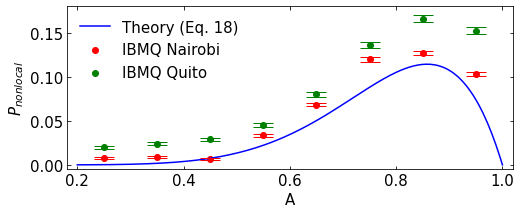

In [17]:
# plot
n=3
split = 8
cm=1/2.54
#fig = plt.figure(figsize=(15.96*cm , 6.913*cm))
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
A_exp = np.linspace(0.25,0.95,split)
A_theo = np.linspace(0.2,1+0.0000001,201)
x = A_theo
y = (x**(2*n))-n*x**(4*n-2)*(1-x**2)/(1-x**(2*n)) #theoretical line
plt.plot(A_theo,y,label='Theory (Eq. 18)',color='blue') #theoretical line
#plt.scatter(A_exp,nonlist) 
plt.scatter(A_exp,nonlist_m,label='IBMQ Nairobi',color='r') #Experimental line
plt.errorbar(A_exp,nonlist_m, yerr=std,color='r',capsize = 10,linestyle='')
plt.scatter(A_exp,nonlist_m_quito,label='IBMQ Quito',color='g') #Experimental line
plt.errorbar(A_exp,nonlist_m_quito, yerr=std_quito,color='g',capsize = 10,linestyle='')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True,  # labels along the bottom edge are off
    direction="in", labelsize=15) 

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=True,         # ticks along the top edge are off
    labelleft=True,  # labels along the bottom edge are off
    direction="in", labelsize=15) 

plt.xlabel('A',size=15)
plt.ylabel('$P_{nonlocal}$',size=15)
plt.legend(loc = 'upper left',fontsize=15,framealpha = 0)
#plt.title('$|\Psi>$',size=20)
plt.yticks([0,0.05,0.1,0.15])
plt.xticks([0.2,0.4,0.6,0.8,1])
plt.xlim(0.18, 1.02)
plt.ylim(bottom=-0.005, top = 0.18)
#plt.savefig('NairobiQuito_Psi_big.svg', transparent = True, dpi=240)
plt.show()

To demonstrate its practical aspect, we execute the 'third conditions' quantum circuit on IBM's quantum computers Nairobi and Quito using Qiskit, averaging from 2 million shots each, equally divided into 100 different runs. The systematic errors on Quito are slightly larger than those on Nairobi. These are the best results we obtain from IBM's transmon processors. Any experiment for $n > 3$ yields result with big error, as compared to IBM's own QASM simulator.

# 3. von Neumannn entropy

## 3.1. at changing A

Prepare circuits at A change from 0 to 1, and measure von Neumann entropy at half-chain

In [18]:
vne = {}

for n in [2,5,11]:
    start = time.time()
#--------this part is to calculate von Neumann entropy to theta angles

    A = np.linspace(0,1-(10**-9),10**2)
    theta = np.arcsin(A)*2
    vne[n] = []

    for t in theta:
        anc = QuantumRegister(1)
        q = QuantumRegister(n)
        c = ClassicalRegister(1+n)
        qc = QuantumCircuit(q, anc,c)

        qc.ry(t,q)
        qc.mct(q[0:n],anc[0],mode='noancilla') 

        backend = Aer.get_backend('statevector_simulator')
        job = execute(qc, backend)
        result = job.result()
        outputstate = result.get_statevector(qc)
        keep_length = 2**n
        del_length = 2**(n+1)-keep_length
        partialstate = np.delete(outputstate,np.arange(del_length)+keep_length)
        normed_tensor = (partialstate/np.linalg.norm(partialstate))
        partialtraceA =  get_subsystem_density_matrix(normed_tensor,range(n//2))
        vne[n].append(quantum_info.entropy(partialtraceA))

end = time.time()
print(end-start)

13.553115844726562


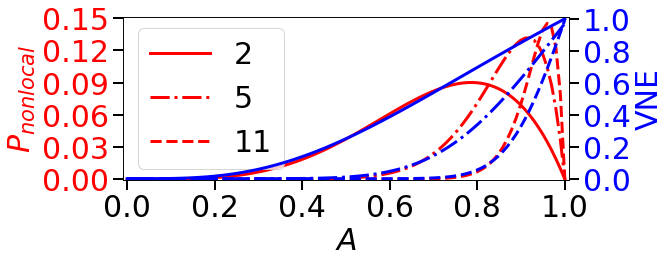

In [19]:
clist = ['red','green','blue','orange','black']
lslist = ['solid','dashdot','dashed','dotted', (0, (3, 1, 1, 1, 1, 1)), (0, (1, 1))]
lwlist = [2,2,3]
fig, ax1 = plt.subplots(figsize=(8,3))
plt.yticks(np.linspace(0.,0.15,6))
ax2 = ax1.twinx()

nonloc = {}
i=0

for n in [2,5,11]:
    x=A
    nonloc[n] = list((x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n)))
    ax1.set_xscale('linear')
    ax2.set_xscale('linear')
    ax1.plot(x, nonloc[n], linestyle = lslist[i], color = 'r', label = '%s'%(n),linewidth=3)
    ax2.plot(A, vne[n], linestyle = lslist[i],color = 'b', label = '%s'%(n),linewidth=3)
    i+=1

ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.tick_params(axis='both', which='minor', labelsize=30)
ax1.tick_params(axis='y',width=2,length=10)
ax1.tick_params(axis='x',width=2,length=10)
for i in range(6):
    ax1.get_yticklabels()[i].set_color('red')
ax1.set_ylim(ymin=-0.001,ymax=0.151)
ax1.set_xlim(xmin=-0.01,xmax=1.01)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='minor', labelsize=30)
ax2.tick_params(axis='y',width=2,length=10)
for i in range(4):
    ax2.get_yticklabels()[i].set_color('blue')
ax2.set_ylim(ymin=-0.01,ymax=1.01)
ax1.set_xlabel('$A$',fontsize = '30')
ax1.set_ylabel('$P_{nonlocal}}$', color='r',fontsize = '30')
ax2.set_ylabel('VNE', color='b',fontsize = '30')
ax1.legend(fontsize='30',loc='center left')
plt.yticks(np.linspace(0,1,6))
plt.xticks(np.linspace(0,1,6))

plt.show()

We found their behavior to agree up to the "optimal point" of $A$ before diverging; while $P_\text{nonlocal}$ increases to a maximum and then decreases sharply, $S(\rho_{\lfloor n/2 \rfloor})$ grows monotonically. This implies that high entanglement does not always correlate to high nonlocality

## 3.2. at optimal A

Prepare circuits at optimal A, and measure von Neumann entropy at half-chain

In [12]:
np.seterr(divide='ignore', invalid='ignore') #ignore divide by zero warning
#find where maximal nonlocality is
plist = [] #maximal nonlocal probability
tlist = [] #theta of maximal nonlocal probability
Alist = [] #A of maximal nonlocal probability

nmax = 14
nlist = range(2,nmax+1)
for n in nlist:
    
    x=np.linspace(0,1,10**6+1)
    y=(x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
    maxy0 = max(y) #find maximal nonlocal probability for each n
    A0=x[np.nanargmax(y)]
    theta0 = np.arcsin(A0)*2/pi
    plist.append(maxy0)
    Alist.append(A0)
    tlist.append(theta0)

print('Optimal theta list for |Psi>')
print(tlist)
prob0 = plist.copy() #optimal nonlocal probability for each n

Optimal theta list for |Psi>
[0.5758584150269528, 0.6568937101191508, 0.7041698203530722, 0.7360819027778901, 0.7594843379498253, 0.7775905627369931, 0.7921402753443038, 0.8041632115758095, 0.8143148986367293, 0.8230354154233489, 0.8306322389741668, 0.8373258851836116, 0.8432862623476818]


In [21]:
vne = []

for (t,n) in zip(tlist,nlist):
    start = time.time()
    anc = QuantumRegister(1)
    q = QuantumRegister(n)
    c = ClassicalRegister(1+n)
    qc = QuantumCircuit(q, anc,c)

    theta = t*pi
    qc.ry(theta,q)
    qc.mct(q[0:n],anc[0],mode='noancilla')

    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    outputstate = result.get_statevector(qc)
    keep_length = 2**n
    del_length = 2**(n+1)-keep_length
    partialstate = np.delete(outputstate,np.arange(del_length)+keep_length)
    normed_tensor = (partialstate/np.linalg.norm(partialstate))
    partialtraceA =  get_subsystem_density_matrix(normed_tensor,range(n//2))

    #------VNE------ 
    en=quantum_info.entropy(partialtraceA)
    vne.append(en) #VNE qiskit
    end = time.time()
    print(n,'vne =',en, 'time =',end-start)
    
vne_psihalf = vne.copy()

2 vne = 0.6742484103581537 time = 0.014996528625488281
3 vne = 0.6315144404432419 time = 0.013953208923339844
4 vne = 0.6947208903883676 time = 0.014958858489990234
5 vne = 0.6778881321052296 time = 0.019946813583374023
6 vne = 0.7007508078465094 time = 0.0213010311126709
7 vne = 0.6919280701002659 time = 0.022760629653930664
8 vne = 0.7036370504665892 time = 0.02833724021911621
9 vne = 0.6982325379929355 time = 0.03358721733093262
10 vne = 0.7053340293384015 time = 0.05817151069641113
11 vne = 0.701687169840619 time = 0.14284801483154297
12 vne = 0.7064492883291809 time = 0.4528465270996094
13 vne = 0.7038180987179816 time = 1.4076025485992432
14 vne = 0.7072353492927422 time = 5.7758448123931885


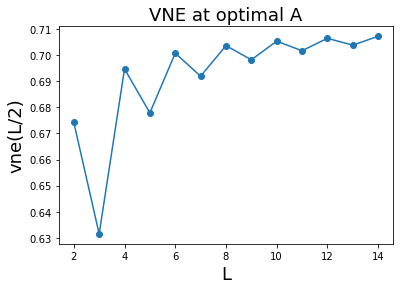

In [22]:
plt.plot(nlist,vne,marker='o')
plt.title('VNE at optimal A',fontsize = 18)
plt.xlabel('L',fontsize = 18)
plt.ylabel('vne(L/2)',fontsize = 18)
plt.show()

### Python fitting

R² = 0.664580103866439
Y = -0.08678594235804195 * e^(-0.2558575245032528 * x) + 0.7088641378364846


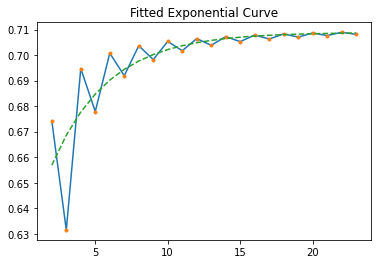

In [23]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

xs = np.arange(2,24)
#xs = np.insert(xs,0,0)
#longer vne_psihalf to use for fitting
vne_psihalf_atmax = [0.6742490161589452, 0.6315148728355223, 0.694720466734074, 0.6778876290820022, 0.7007500357476585, 0.6919302242450397, 
                  0.703636727607502, 0.698230534487789, 0.705330994952347, 0.7016850673301973, 0.7064464196035658, 0.7038211605187019, 
                  0.7072316648628474, 0.7052565730678905, 0.7078216020716394, 0.7062776963698504, 0.7082782612147291, 0.7070381702107751,
                  0.7086406297004567, 0.7076193310559658, 0.7089301410086082, 0.7080841985646434]
ys = vne_psihalf_atmax
plt.plot(xs, ys)
plt.title("Original Data")

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

# perform the fit
p0 = (0,1,1) # fit algo initial guess of m, t, b, default is [1,1,1]
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys,p0)
m, t, b = params

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, m, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# plot the results
plt.plot(xs, ys, '.', label="data")
plt.plot(xs, monoExp(xs, m, t, b), '--', label="fitted")
plt.title("Fitted Exponential Curve")

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}")
#fit code from https://swharden.com/blog/2020-09-24-python-exponential-fit/

Text(0.5, 1.0, 'Extrapolated Exponential Curve')

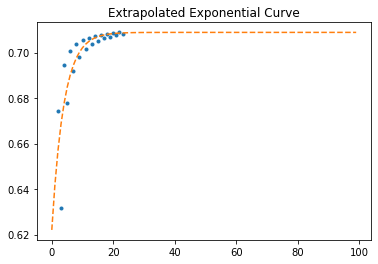

In [24]:
xs2 = np.arange(100)
ys2 = monoExp(xs2, m, t, b)

plt.plot(xs, ys, '.', label="data")
plt.plot(xs2, ys2, '--', label="fitted")
plt.title("Extrapolated Exponential Curve")

## 3.3. at constant A

Prepare circuits at constant A, and measure von Neumann entropy at half-chain

In [2]:
nmax = 14
nlist = range(2,nmax+1)
Alist = [0.1,0.5,0.7,0.9]
tlist = np.arcsin(Alist)*2

vnehalfA = []
pA = []
for t in tlist:
    start = time.time()
    plist = []
    vne = []
    for n in nlist:
        
        anc = QuantumRegister(1)
        q = QuantumRegister(n)
        c = ClassicalRegister(1+n)
        qc = QuantumCircuit(q, anc,c)

        theta = t
        qc.ry(theta,q)
        qc.mct(q[0:n],anc[0],mode='noancilla') 

        backend = Aer.get_backend('statevector_simulator')
        job = execute(qc, backend)
        result = job.result()
        outputstate = result.get_statevector(qc)
        keep_length = 2**n
        del_length = 2**(n+1)-keep_length
        partialstate = np.delete(outputstate,np.arange(del_length)+keep_length)
        normed_tensor = (partialstate/np.linalg.norm(partialstate))
        partialtraceA =  get_subsystem_density_matrix(normed_tensor,range(n//2))

        #------VNE------ 
        en=quantum_info.entropy(partialtraceA)
        vne.append(en) #VNE qiskit
        
        #----Nonlocal probability-----------
        x=np.sin(theta/2)
        y=(x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n))
        plist.append(y)
    vnehalfA.append(vne)
    pA.append(plist)
    end = time.time()
    
    print('theta = %s pi'%(theta/pi),', time =',end-start)
    #print('vne =',vne)
    #print('prob = ',plist, '\n')

theta = 0.06376856085851985 pi , time = 10.294904947280884
theta = 0.33333333333333337 pi , time = 7.86800479888916
theta = 0.49363337778673 pi , time = 7.496653318405151
theta = 0.7128674137425874 pi , time = 7.636117696762085


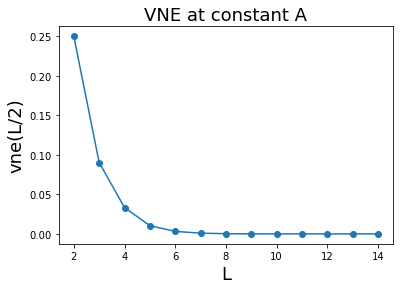

In [3]:
plt.plot(nlist,vnehalfA[1],marker='o')
plt.title('VNE at constant A',fontsize = 18)
plt.xlabel('L',fontsize = 18)
plt.ylabel('vne(L/2)',fontsize = 18)
plt.show()

## 3.4. Overall

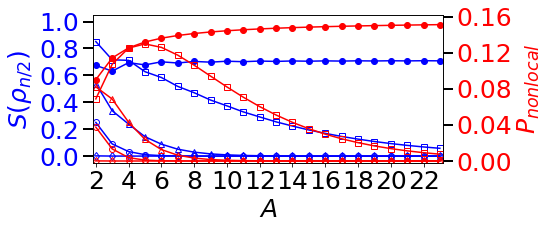

Increase nmax=16 would give Figure 3 in the article.


In [2]:
vne_psihalf_atmax = [0.6742490161589452, 0.6315148728355223, 0.694720466734074, 0.6778876290820022, 0.7007500357476585, 0.6919302242450397, 
                  0.703636727607502, 0.698230534487789, 0.705330994952347, 0.7016850673301973, 0.7064464196035658, 0.7038211605187019, 
                  0.7072316648628474, 0.7052565730678905, 0.7078216020716394, 0.7062776963698504, 0.7082782612147291, 0.7070381702107751,
                  0.7086406297004567, 0.7076193310559658, 0.7089301410086082, 0.7080841985646434]
vne_psihalf_atmax = [0.6742490161589452, 0.6315148728355223, 0.694720466734074, 0.6778876290820022, 0.7007500357476585,
                     0.6919302242450397, 0.703636727607502, 0.698230534487789, 0.705330994952347, 0.7016850673301973, 
                     0.7064464196035658, 0.7038211605187019, 0.7072316648628474, 0.7052565730678905, 0.7078216020716394, 
                     0.7062776963698504, 0.7082782612147291, 0.7070381702107751, 0.7086406297004567, 0.7076193310559658, 
                     0.7089301410086082, 0.7080841985646434]
vne_psihalf_09 = [0.8513234158681869 , 0.7158026774987507 , 0.7117376721606093 , 0.6274109674776034 , 0.584322601182178 ,
                  0.5181110097212885 , 0.4712025992505785 , 0.41667968007943146 , 0.3734446757425548 , 0.3284790026541751 ,
                  0.29111006375987186 , 0.25448868487680565 , 0.2234257131905938 , 0.19410169422014228 , 0.16902278113602073 ,
                  0.1459574750590048 , 0.12618810161351102 , 0.10835668043300292 , 0.09308697061647986 , 0.0795218652162643 ,
                  0.06793373454552244 , 0.05776416848190476 ]
vne_psihalf_07 = [0.5389650018089603, 0.3371580448106136, 0.23772416820171582, 0.1441066736934534, 0.08868769188416235, 
                  0.05106187380097988, 0.029294474263020627, 0.01621775537307756, 0.008921750276894758, 0.004810001786970196,
                  0.002578516417236257, 0.001365900608988161, 0.0007202358763040228, 0.0003769744914094135, 0.0001965911616553261,
                  0.00010202077586130317, 5.278849414011106e-05, 2.7220209925999212e-05, 1.4002404206311426e-05, 7.184468155541913e-06, 
                  3.678931375249891e-06, 1.880057532666855e-06]
vne_psihalf_05 = [0.2502249116110707, 0.09038420564872632, 0.033368789040049515, 0.01044229968715347, 0.0031929259110844727,
                  0.0009260435291326816, 0.00026426101288019237, 7.383368643324925e-05, 2.04121639896486e-05, 5.5827758843406135e-06,
                  1.51580461404249e-06, 4.088098558274714e-07, 1.0966986968100462e-07, 2.928123173907447e-08, 7.786279692050226e-09,
                  2.0629977114485342e-09, 5.448517861989643e-10, 1.4316180091064655e-10, 3.72723893430486e-11, 1.0016829240603739e-11,
                  0,0]
vne_psihalf_01 = [0.0014469515664689366, 2.1172959209029977e-05, 2.8012805773152015e-07, 3.465861797641253e-09, 4.130745749592723e-11,
                  4.795224103785555e-13, 1.0390853682189901e-14, 4.642104417346425e-15, 2.520947811164827e-16, 2.977522790080157e-14,
                  2.4581223515581207e-14, 8.464595826760066e-14, 2.928760087032605e-15, 5.479929721786091e-15, 2.3389386608058626e-14,
                  0,0,0,0,0,0,0]

prob0 = [0.09016994374928805, 0.11423300751219556, 0.12543446024939808, 0.1319159554472107, 0.13614255532176228, 
         0.13911688864710053, 0.14132378576932214, 0.14302637050975103, 0.14437980306451947, 0.14548150762515155, 
         0.14639574390984111, 0.1471666134225723, 0.14782538960008534, 0.1483948661322268, 0.1488920487106296, 
         0.1493298826450286, 0.14971839644673224, 0.15006547966223088, 0.1503774241210324, 0.15065930910789121, 
         0.1509152798412146, 0.1511487528725849]

nmax=23  
nlist = np.arange(2,nmax+1)
Arange = [0.1, 0.5, 0.7, 0.9]
strlis=['','','','','','','~']
mklist = ['d','o','^','s']
lwlist = [2,2,3]
cm = 1/2.54
fig, ax2 = plt.subplots(figsize=(15.96*cm , 6.913*cm))
ax1 = ax2.twinx()
ax2.zorder=0
ax1.zorder=5
ax2.set_yticks(np.linspace(0,1,6))
ax1.set_yticks(np.linspace(0,0.16,5))

#---------only for drawing to nmax=23------------------
vnehalfA = []
vnehalfA.append(vne_psihalf_01)
vnehalfA.append(vne_psihalf_05)
vnehalfA.append(vne_psihalf_07)
vnehalfA.append(vne_psihalf_09)

pA = []
for x in Arange:
    n = nlist
    pA.append((x**(2*n))+n*x**(4*n-2)*(x**2-1)/(1-x**(2*n)))
vne_psihalf = vne_psihalf_atmax

#-------------------
i=0
for (A,str) in zip(Arange,strlis):

    ax1.plot(nlist,pA[i], color='red',marker=mklist[i],fillstyle='none',label=r'%s$%s$'%(str,np.round(A,3)))
    ax2.plot(nlist,vnehalfA[i],color='blue',marker=mklist[i],fillstyle='none',label=r'%s$%s$'%(str,np.round(A,3)))
    i+=1
ax1.plot(nlist,prob0,linestyle='-',color='red',marker='o',label='Optimal')
ax2.plot(nlist,vne_psihalf,linestyle='-',color='blue',marker='o',label='Optimal')
#---------------------

ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.tick_params(axis='both', which='minor', labelsize=25)
ax1.tick_params(axis='y',width=2,length=10)
ax1.tick_params(axis='x',width=2,length=10)
for i in range(5):
    ax1.get_yticklabels()[i].set_color('red')

ax2.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='minor', labelsize=25)
ax2.tick_params(axis='y',width=2,length=10)

for i in range(6):
    ax2.get_yticklabels()[i].set_color('blue')

ax2.set_xlabel('$A$',fontsize = '25')
ax1.set_ylabel('$P_{nonlocal}$', color='r',fontsize = '25')
ax2.set_ylabel(r'$S(\rho_{n/2})$', color='b',fontsize = '25')

plt.xticks(range(2,nmax+1,2))
plt.xlim(xmin=1.8,xmax=nmax+0.2)
ax1.set_ylim(ymin=-0.002,ymax=0.162)
ax2.set_ylim(ymin=-0.05,ymax=1.05)

plt.show()
print('Increase nmax=16 would give Figure 3 in the article.')

Only for optimal $A$, $P_\text{nonlocal}$ and $S(\rho_{\lfloor n/2 \rfloor})$ approach a constant as $n$ grows, as shown by solid circles

## 4. Summary

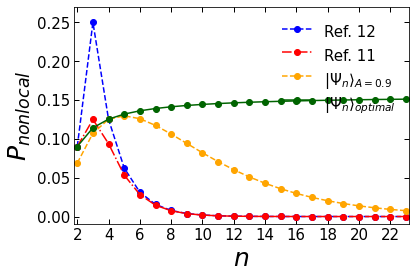

In [7]:
nlist = np.arange(2,24)
prob0 = [0.09016994374928805, 0.11423300751219556, 0.12543446024939808, 0.1319159554472107, 0.13614255532176228, 
         0.13911688864710053, 0.14132378576932214, 0.14302637050975103, 0.14437980306451947, 0.14548150762515155, 
         0.14639574390984111, 0.1471666134225723, 0.14782538960008534, 0.1483948661322268, 0.1488920487106296, 
         0.1493298826450286, 0.14971839644673224, 0.15006547966223088, 0.1503774241210324, 0.15065930910789121, 
         0.1509152798412146, 0.1511487528725849]
prob09 = [0.06887238, 0.10727518, 0.12519309, 0.12975447, 0.12597956,
       0.11734571, 0.1062119 , 0.09413552, 0.08210684, 0.07072122,
       0.06030423, 0.0510017 , 0.04284354, 0.03578845, 0.02975454,
       0.02463993, 0.02033611, 0.01673635, 0.01374056, 0.01125787,
       0.00920766, 0.00751964]

fig, ax1 = plt.subplots(figsize=(6,4))

ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.tick_params(axis='y',width=1,length=5,direction="in")
ax1.tick_params(axis='x',width=1,length=5,direction="in")

    
yg = 1/(2**(nlist-1))
ys = 1/(2**(nlist))*(1+cos(pi/(nlist-1)))
yg = yg[1:]
ys = ys[1:]
yg = np.insert(yg, 0, (5*np.sqrt(5)-11)/2)
ys = np.insert(ys, 0, (5*np.sqrt(5)-11)/2)

plt.plot(nlist,yg, linestyle='--', color='blue',marker='o',label='Ref. 12')
plt.plot(nlist,ys, linestyle='-.', color='red',marker='o',label='Ref. 11')
plt.plot(nlist,prob09, linestyle='dashed', color='orange',marker='o',label=r'|$\Psi_n \rangle_{A=0.9}$')
plt.plot(nlist,prob0,linestyle='-',color='darkgreen',marker='o',label=r'|$\Psi_n \rangle_{optimal}$')

plt.xticks(range(2,24,2))
plt.yticks(np.linspace(0,0.25,6))
ax1.set_ylim(ymin=-0.01,ymax=0.27)
ax1.set_xlim(xmin=1.8,xmax=23.2)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)


#plt.legend(fontsize='25',loc='upper left', fancybox=True, framealpha=0, ncol=2, handleheight=2.4, labelspacing=0.05)
plt.legend(fontsize='15',loc='upper right', fancybox=True, framealpha=0, handleheight=2, labelspacing=0.05, ncol=1)
plt.xlabel(r'$n$',fontsize='25')
plt.ylabel('$P_{nonlocal}$',fontsize='25')
plt.savefig('Summary.svg', dpi = 240)
plt.show()

As $n$ grows, $P_\text{nonlocal}$ quickly reduces to zero at fixed $A$ for a representative value $A$ = 0.9. This observation matches with previous work on generalized GHZ states. At $n$ = 2, $P_\text{nonlocal}$ = 9\% because they are all equal to the original Hardy's result. The fast reduction of $P_\text{nonlocal}$ of the Reference states at large $n$ might relates to the nature of GHZ states. Although maximally entangled, GHZ states do not necessarily reach maximum in nonlocality. There is an optimum value of $A = |A_k| \ \forall k \in\Omega$ that $P_\text{nonlocal}$ is maximized whereas the entanglement entropy $S(\rho_{\lfloor n/2 \rfloor})$ behaves monotonically.